# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",1000)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.97509982675167528

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            #loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20','time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}'
                                                                         .format(h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})

                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    if epoch % 1 == 0:
                        print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}, {:6f}"
                              .format(epoch, train_loss, test_loss, test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):
                                                  (curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h,valid_accuracy, test_accuracy, test_accuracy_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [ ]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1, 8, 32, 122]
        hidden_layers_arr = [1, 3, 5]

        epochs = [20]
        lrs = [1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_vae_dense_trained_together_nsl_kdd-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd-.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd-.pkl")


In [ ]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:20 hidden layers:1 features count:1
Step 1 | Training Loss: 0.000173 | Test Loss: 0.002155 | Test Accuracy: 0.793648, 0.670211
Step 2 | Training Loss: 0.001499 | Test Loss: 0.121836 | Test Accuracy: 0.636444, 0.338481
Step 3 | High Training Loss: 17010828.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_1/model-1
Step 3 | Training Loss: 0.000036 | Test Loss: 0.008100 | Test Accuracy: 0.688343, 0.476456
Step 4 | Training Loss: 0.000067 | Test Loss: 0.003412 | Test Accuracy: 0.625976, 0.414768
Step 5 | Training Loss: 0.000157 | Test Loss: 0.031200 | Test Accuracy: 0.734120, 0.536709
Step 6 | Training Loss: 0.001906 | Test Loss: 0.039710 | Test Accuracy: 0.713937, 0.492574
Step 7 | Training Loss: 0.000312 | Test Loss: 0.010029 | Test Accuracy: 0.776881, 0.603882
Step 8 | Training Loss: 0.002480 | Test Loss: 0.002250 | Test Accuracy: 0.833614, 0.692827
Step 9 | 

Step 2 | High Training Loss: 4573546.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 17425554.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 17425606.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 17425870.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 17426140.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 17

Step 12 | High Training Loss: 12720347136.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 18702307589964131467264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 18702307589964131467264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 18702307589964131467264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 18702307589964131467264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidd

Step 16 | High Training Loss: 18517136461785259311104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 16 | High Training Loss: 18517136461785259311104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 16 | High Training Loss: 18517136461785259311104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 16 | High Training Loss: 18517136461785259311104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 16 | High Training Loss: 18517136461785259311104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_n

Step 2 | Training Loss: 0.000074 | Test Loss: 0.000326 | Test Accuracy: 0.853708, 0.729198
Step 3 | High Training Loss: 2365113.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 30542.824219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | Training Loss: 0.001880 | Test Loss: 5681241542098944.000000 | Test Accuracy: 0.664212, 0.371139
Step 4 | High Training Loss: 817496089165824.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 5244556.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Trainin

Step 10 | Training Loss: 0.023693 | Test Loss: 10267.621094 | Test Accuracy: 0.860495, 0.749958
Step 11 | High Training Loss: 3165164069191680.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 11 | Training Loss: 0.002885 | Test Loss: 0.009246 | Test Accuracy: 0.778433, 0.663122
Step 12 | High Training Loss: 75534584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 12 | High Training Loss: 1172678144.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 12 | Training Loss: 0.000643 | Test Loss: 4763016725790720.000000 | Test Accuracy: 0.659289, 0.363629
Step 13 | High Training Loss: 28612567467294720.000000 ... Restoring Net
INFO:tensorflow:Restoring paramete

Step 7 | High Training Loss: 4860342173696.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-16
Step 7 | High Training Loss: 4860342697984.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-16
Step 7 | High Training Loss: 4860342697984.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-16
Step 7 | Training Loss: 0.000204 | Test Loss: 0.542261 | Test Accuracy: 0.868391, 0.751646
Step 8 | High Training Loss: 60240.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-16
Step 8 | Training Loss: 0.001062 | Test Loss: 1661.117065 | Test Accuracy: 0.837296, 0.694768
Step 9 | High Train

Step 7 | Training Loss: 0.000080 | Test Loss: 0.000224 | Test Accuracy: 0.789611, 0.624979
Step 8 | Training Loss: 0.000040 | Test Loss: 0.000229 | Test Accuracy: 0.773731, 0.599156
Step 9 | Training Loss: 0.000001 | Test Loss: 0.000249 | Test Accuracy: 0.777546, 0.607257
Step 10 | Training Loss: 0.000090 | Test Loss: 0.000241 | Test Accuracy: 0.778966, 0.606245
Step 11 | Training Loss: 0.000142 | Test Loss: 0.000285 | Test Accuracy: 0.785309, 0.615106
Step 12 | Training Loss: 0.000045 | Test Loss: 0.000245 | Test Accuracy: 0.781228, 0.611224
Step 13 | Training Loss: 0.000091 | Test Loss: 0.000230 | Test Accuracy: 0.783313, 0.615021
Step 14 | Training Loss: 0.000013 | Test Loss: 0.000255 | Test Accuracy: 0.781183, 0.607089
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000276 | Test Accuracy: 0.787881, 0.614093
Step 16 | Training Loss: 0.000012 | Test Loss: 0.000258 | Test Accuracy: 0.785353, 0.616203
Step 17 | Training Loss: 0.000113 | Test Loss: 0.000260 | Test Accuracy: 0.785841, 

Step 13 | Training Loss: 0.000027 | Test Loss: 0.000290 | Test Accuracy: 0.798128, 0.632152
Step 14 | Training Loss: 0.000017 | Test Loss: 0.000224 | Test Accuracy: 0.827626, 0.702110
Step 15 | Training Loss: 0.000052 | Test Loss: 0.000160 | Test Accuracy: 0.832372, 0.692152
Step 16 | Training Loss: 0.000190 | Test Loss: 0.000252 | Test Accuracy: 0.850515, 0.733333
Step 17 | Training Loss: 0.000068 | Test Loss: 0.000194 | Test Accuracy: 0.871052, 0.780506
Step 18 | Training Loss: 0.000011 | Test Loss: 0.000215 | Test Accuracy: 0.783046, 0.594346
Step 19 | Training Loss: 0.000018 | Test Loss: 0.000184 | Test Accuracy: 0.825053, 0.677890
Step 20 | Training Loss: 0.000044 | Test Loss: 0.000184 | Test Accuracy: 0.823235, 0.676118
Step 1 | Training Loss: 0.000056 | Test Loss: 0.000134 | Test Accuracy: 0.819331, 0.666245
Step 2 | Training Loss: 0.000022 | Test Loss: 0.000157 | Test Accuracy: 0.817956, 0.662194
Step 3 | Training Loss: 0.000031 | Test Loss: 0.000158 | Test Accuracy: 0.817956, 

Step 16 | Training Loss: 0.000236 | Test Loss: 0.000141 | Test Accuracy: 0.502262, 0.356203
Step 17 | Training Loss: 0.000219 | Test Loss: 0.000344 | Test Accuracy: 0.490330, 0.269030
Step 18 | Training Loss: 0.000031 | Test Loss: 0.000285 | Test Accuracy: 0.502085, 0.358228
Step 19 | Training Loss: 0.000106 | Test Loss: 0.000250 | Test Accuracy: 0.513485, 0.408945
Step 20 | Training Loss: 0.000431 | Test Loss: 0.000137 | Test Accuracy: 0.512065, 0.397046
Step 1 | Training Loss: 0.000128 | Test Loss: 0.000159 | Test Accuracy: 0.509803, 0.373249
Step 2 | Training Loss: 0.000039 | Test Loss: 0.000172 | Test Accuracy: 0.508605, 0.416118
Step 3 | Training Loss: 0.000029 | Test Loss: 0.000136 | Test Accuracy: 0.501597, 0.368776
Step 4 | Training Loss: 0.000191 | Test Loss: 0.000135 | Test Accuracy: 0.500133, 0.381181
Step 5 | Training Loss: 0.000061 | Test Loss: 0.000135 | Test Accuracy: 0.503016, 0.380928
Step 6 | Training Loss: 0.000159 | Test Loss: 0.000175 | Test Accuracy: 0.508073, 0.3

Step 17 | Training Loss: 0.000862 | Test Loss: 0.000985 | Test Accuracy: 0.458703, 0.329789
Step 18 | Training Loss: 0.000737 | Test Loss: 0.000967 | Test Accuracy: 0.464824, 0.346751
Step 19 | Training Loss: 0.000755 | Test Loss: 0.000960 | Test Accuracy: 0.447259, 0.277384
Step 20 | Training Loss: 0.000577 | Test Loss: 0.000948 | Test Accuracy: 0.465090, 0.314768
Step 1 | Training Loss: 0.000539 | Test Loss: 0.000920 | Test Accuracy: 0.435726, 0.207342
Step 2 | Training Loss: 0.000642 | Test Loss: 0.000984 | Test Accuracy: 0.432665, 0.186498
Step 3 | Training Loss: 0.000659 | Test Loss: 0.001016 | Test Accuracy: 0.435326, 0.204219
Step 4 | Training Loss: 0.000646 | Test Loss: 0.000954 | Test Accuracy: 0.432665, 0.190127
Step 5 | Training Loss: 0.000534 | Test Loss: 0.000937 | Test Accuracy: 0.432000, 0.188692
Step 6 | Training Loss: 0.000535 | Test Loss: 0.000960 | Test Accuracy: 0.431334, 0.189536
Step 7 | Training Loss: 0.000721 | Test Loss: 0.000961 | Test Accuracy: 0.433463, 0.19

Step 2 | Training Loss: 0.000050 | Test Loss: 0.000710 | Test Accuracy: 0.730172, 0.490464
Step 3 | Training Loss: 0.000105 | Test Loss: 0.000679 | Test Accuracy: 0.729684, 0.488354
Step 4 | Training Loss: 0.000046 | Test Loss: 0.000491 | Test Accuracy: 0.737935, 0.509958
Step 5 | Training Loss: 0.000175 | Test Loss: 0.000443 | Test Accuracy: 0.742149, 0.515274
Step 6 | Training Loss: 0.000082 | Test Loss: 0.000422 | Test Accuracy: 0.743435, 0.519409
Step 7 | Training Loss: 0.000034 | Test Loss: 0.000424 | Test Accuracy: 0.752440, 0.531224
Step 8 | Training Loss: 0.000063 | Test Loss: 0.000387 | Test Accuracy: 0.750222, 0.532489
Step 9 | Training Loss: 0.000109 | Test Loss: 0.000313 | Test Accuracy: 0.749068, 0.529198
Step 10 | Training Loss: 0.000020 | Test Loss: 0.000177 | Test Accuracy: 0.748669, 0.526498
Step 11 | Training Loss: 0.000008 | Test Loss: 0.000181 | Test Accuracy: 0.755190, 0.540169
Step 12 | Training Loss: 0.000072 | Test Loss: 0.000201 | Test Accuracy: 0.748359, 0.523

Step 4 | Training Loss: 0.000078 | Test Loss: 0.002711 | Test Accuracy: 0.737447, 0.508692
Step 5 | High Training Loss: 18814.052734 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 5 | Training Loss: 0.001419 | Test Loss: 311374.218750 | Test Accuracy: 0.748891, 0.527764
Step 6 | High Training Loss: 1573999.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 6 | High Training Loss: 406140.187500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 6 | Training Loss: 0.000666 | Test Loss: 0.001367 | Test Accuracy: 0.806600, 0.636540
Step 7 | Training Loss: 0.003493 | Test Loss: 0.007417 | Test Accuracy: 0.751242, 0.530464
Step 8 | Training Loss: 0.000434 | Test Loss: 0.001223 

Step 2 | High Training Loss: 262585.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 262584.718750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 262589.093750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 262581.093750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 262584.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: 262581

Step 3 | High Training Loss: 597544832.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 597544320.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 597543872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 597544768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 597544448.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Traini

Step 5 | High Training Loss: 125216447966107140096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 24474147618816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 24474147618816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 24474147618816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 5 | High Training Loss: 24474147618816.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_

Step 8 | Training Loss: 0.013718 | Test Loss: 0.375388 | Test Accuracy: 0.865951, 0.749536
Step 9 | High Training Loss: 195532.718750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 23208246.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 18864238592.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 18864236544.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: 18864230400.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_de

Step 15 | Training Loss: 0.004386 | Test Loss: inf | Test Accuracy: 0.857479, 0.732911
Step 16 | High Training Loss: 8674980921344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 16 | High Training Loss: 9093398.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 16 | High Training Loss: 1596025077760.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 16 | High Training Loss: 18864230400.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 16 | High Training Loss: 18864234496.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/

Step 17 | High Training Loss: 18864244736.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 17 | High Training Loss: 18864267264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 17 | Training Loss: 0.001239 | Test Loss: 0.002333 | Test Accuracy: 0.866439, 0.750211
Step 18 | Training Loss: 0.000528 | Test Loss: 0.001619 | Test Accuracy: 0.860584, 0.736878
Step 19 | Training Loss: 0.000222 | Test Loss: 0.001929 | Test Accuracy: 0.850027, 0.716371
Step 20 | Training Loss: 0.000526 | Test Loss: 0.000509 | Test Accuracy: 0.846034, 0.711477
Best Accuracy on Test data: 0.8664389848709106
Current Layer Attributes - epochs:20 hidden layers:3 features count:1
Step 1 | Training Loss: 0.000133 | Test Loss: 0.000375 | Test Accuracy: 0.712030, 0.645401
Step 2 | Training Loss: 0.

Step 18 | Training Loss: 0.000004 | Test Loss: 0.000202 | Test Accuracy: 0.787349, 0.636962
Step 19 | Training Loss: 0.000033 | Test Loss: 0.000189 | Test Accuracy: 0.788325, 0.635105
Step 20 | Training Loss: 0.000009 | Test Loss: 0.000180 | Test Accuracy: 0.788680, 0.638312
Best Accuracy on Test data: 0.868080198764801
Current Layer Attributes - epochs:20 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000232 | Test Loss: 0.000422 | Test Accuracy: 0.816803, 0.678903
Step 2 | Training Loss: 0.000047 | Test Loss: 0.002722 | Test Accuracy: 0.814807, 0.712827
Step 3 | Training Loss: 0.000085 | Test Loss: 0.000071 | Test Accuracy: 0.850381, 0.729789
Step 4 | Training Loss: 0.000215 | Test Loss: 0.000225 | Test Accuracy: 0.819553, 0.668270
Step 5 | Training Loss: 0.000057 | Test Loss: 0.000253 | Test Accuracy: 0.825053, 0.712152
Step 6 | Training Loss: 0.000025 | Test Loss: 0.000255 | Test Accuracy: 0.855793, 0.784304
Step 7 | Training Loss: 0.000036 | Test Loss: 0.000188 | Test

Step 4 | Training Loss: 0.000043 | Test Loss: 0.000329 | Test Accuracy: 0.696549, 0.568523
Step 5 | Training Loss: 0.000155 | Test Loss: 0.000522 | Test Accuracy: 0.703380, 0.591224
Step 6 | Training Loss: 0.000074 | Test Loss: 0.000109 | Test Accuracy: 0.773110, 0.635865
Step 7 | Training Loss: 0.000046 | Test Loss: 0.000253 | Test Accuracy: 0.806645, 0.668101
Step 8 | Training Loss: 0.000052 | Test Loss: 0.000480 | Test Accuracy: 0.733543, 0.561013
Step 9 | Training Loss: 0.000104 | Test Loss: 0.000411 | Test Accuracy: 0.766634, 0.599916
Step 10 | Training Loss: 0.000140 | Test Loss: 0.000236 | Test Accuracy: 0.797995, 0.660591
Step 11 | Training Loss: 0.000228 | Test Loss: 0.000309 | Test Accuracy: 0.720325, 0.572658
Step 12 | Training Loss: 0.000075 | Test Loss: 0.000423 | Test Accuracy: 0.821682, 0.702869
Step 13 | Training Loss: 0.000079 | Test Loss: 0.000211 | Test Accuracy: 0.764815, 0.638143
Step 14 | Training Loss: 0.000238 | Test Loss: 0.000198 | Test Accuracy: 0.751686, 0.6

Step 10 | Training Loss: 0.000027 | Test Loss: 0.000154 | Test Accuracy: 0.527236, 0.435190
Step 11 | Training Loss: 0.000016 | Test Loss: 0.000143 | Test Accuracy: 0.521868, 0.426329
Step 12 | Training Loss: 0.000034 | Test Loss: 0.000151 | Test Accuracy: 0.518009, 0.421603
Step 13 | Training Loss: 0.000050 | Test Loss: 0.000165 | Test Accuracy: 0.528034, 0.442616
Step 14 | Training Loss: 0.000013 | Test Loss: 0.000159 | Test Accuracy: 0.529720, 0.440338
Step 15 | Training Loss: 0.000028 | Test Loss: 0.000150 | Test Accuracy: 0.526659, 0.444641
Step 16 | Training Loss: 0.000116 | Test Loss: 0.000123 | Test Accuracy: 0.529187, 0.438397
Step 17 | Training Loss: 0.000085 | Test Loss: 0.000125 | Test Accuracy: 0.527857, 0.442616
Step 18 | Training Loss: 0.000016 | Test Loss: 0.000135 | Test Accuracy: 0.518763, 0.448439
Step 19 | Training Loss: 0.000016 | Test Loss: 0.000138 | Test Accuracy: 0.521469, 0.444641
Step 20 | Training Loss: 0.000028 | Test Loss: 0.000155 | Test Accuracy: 0.52475

Step 15 | Training Loss: 0.000101 | Test Loss: 0.000082 | Test Accuracy: 0.851934, 0.756962
Step 16 | Training Loss: 0.000011 | Test Loss: 0.000074 | Test Accuracy: 0.850781, 0.753924
Step 17 | Training Loss: 0.000005 | Test Loss: 0.000063 | Test Accuracy: 0.855527, 0.761266
Step 18 | Training Loss: 0.000061 | Test Loss: 0.000062 | Test Accuracy: 0.837651, 0.727089
Step 19 | Training Loss: 0.000052 | Test Loss: 0.000094 | Test Accuracy: 0.841066, 0.733249
Step 20 | Training Loss: 0.000000 | Test Loss: 0.000078 | Test Accuracy: 0.846301, 0.747932
Best Accuracy on Test data: 0.8563253879547119
Current Layer Attributes - epochs:20 hidden layers:1 features count:1
Step 1 | Training Loss: 0.001520 | Test Loss: 0.001669 | Test Accuracy: 0.784244, 0.607764
Step 2 | Training Loss: 0.000214 | Test Loss: 0.001742 | Test Accuracy: 0.722720, 0.511983
Step 3 | Training Loss: 0.000165 | Test Loss: 0.006773 | Test Accuracy: 0.839425, 0.705063
Step 4 | Training Loss: 0.000993 | Test Loss: 0.013320 | T

Step 20 | Training Loss: 0.000107 | Test Loss: 0.000773 | Test Accuracy: 0.741040, 0.511814
Best Accuracy on Test data: 0.8678140640258789
Current Layer Attributes - epochs:20 hidden layers:1 features count:32
Step 1 | Training Loss: 0.002960 | Test Loss: inf | Test Accuracy: 0.826606, 0.679325
Step 2 | High Training Loss: 29300.767578 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 125645.859375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 53851515467352506368.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 959839828180992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dat

Step 14 | Training Loss: 0.001093 | Test Loss: 0.002469 | Test Accuracy: 0.822791, 0.665738
Step 15 | Training Loss: 0.000554 | Test Loss: 0.002296 | Test Accuracy: 0.819996, 0.661435
Step 16 | Training Loss: 0.000678 | Test Loss: 0.131803 | Test Accuracy: 0.829933, 0.679494
Step 17 | Training Loss: 0.000041 | Test Loss: 0.005177 | Test Accuracy: 0.823589, 0.667173
Step 18 | Training Loss: 0.000268 | Test Loss: 3.127684 | Test Accuracy: 0.797995, 0.617806
Step 19 | Training Loss: 0.000165 | Test Loss: 5.596030 | Test Accuracy: 0.832727, 0.685907
Step 20 | Training Loss: 0.000895 | Test Loss: 2.399437 | Test Accuracy: 0.829267, 0.676371
Best Accuracy on Test data: 0.853397786617279
Current Layer Attributes - epochs:20 hidden layers:1 features count:122
Step 1 | Training Loss: 33089894.000000 | Test Loss: 7655983898253051895480320.000000 | Test Accuracy: 0.609874, 0.502869
Step 2 | High Training Loss: 4112154.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_v

Step 3 | High Training Loss: 1857481605120.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 13043042583838720.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 127283529826326020096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 127283529826326020096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 127283529826326020096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1

Step 4 | High Training Loss: 13578490362411469806501888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 13578490362411469806501888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 13578490362411469806501888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 13578490362411469806501888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 4 | High Training Loss: 13578490362411469806501888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trai

Step 6 | Training Loss: 0.004301 | Test Loss: inf | Test Accuracy: 0.783313, 0.673755
Step 7 | High Training Loss: 39761024605758072815616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 7 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1

Step 12 | High Training Loss: 101817984506460587555815424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 101817984506460587555815424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 12 | High Training Loss: 101817984506460587555815424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 12 | Training Loss: 0.025043 | Test Loss: inf | Test Accuracy: 0.660575, 0.444979
Step 13 | High Training Loss: 125359292416.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 13 | High Training Loss: 24771.761719 ... Restoring Net
INF

Step 15 | High Training Loss: 170778603676405686707574276096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 15 | High Training Loss: 170778603676405686707574276096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 15 | High Training Loss: 170778603676405686707574276096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 15 | High Training Loss: 170778603676405686707574276096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 15 | High Training Loss: 170778603676405686707574276096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters f

Step 17 | High Training Loss: 100632728.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | High Training Loss: 100632960.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | High Training Loss: 100632928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | High Training Loss: 100633856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | High Training Loss: 100634208.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | 

Step 13 | Training Loss: 0.000100 | Test Loss: 0.000433 | Test Accuracy: 0.685415, 0.534515
Step 14 | Training Loss: 0.000174 | Test Loss: 0.000314 | Test Accuracy: 0.748492, 0.630127
Step 15 | Training Loss: 0.000089 | Test Loss: 0.000249 | Test Accuracy: 0.751375, 0.621097
Step 16 | Training Loss: 0.000056 | Test Loss: 0.000281 | Test Accuracy: 0.665720, 0.522025
Step 17 | Training Loss: 0.000075 | Test Loss: 0.000377 | Test Accuracy: 0.671576, 0.527595
Step 18 | Training Loss: 0.000191 | Test Loss: 0.000185 | Test Accuracy: 0.708082, 0.579494
Step 19 | Training Loss: 0.000225 | Test Loss: 0.000327 | Test Accuracy: 0.694464, 0.564051
Step 20 | Training Loss: 0.000186 | Test Loss: 0.000319 | Test Accuracy: 0.727821, 0.609283
Step 1 | Training Loss: 0.000097 | Test Loss: 0.000191 | Test Accuracy: 0.723119, 0.592743
Step 2 | Training Loss: 0.000111 | Test Loss: 0.000244 | Test Accuracy: 0.726402, 0.588523
Step 3 | Training Loss: 0.000079 | Test Loss: 0.000229 | Test Accuracy: 0.732967, 

Step 16 | Training Loss: 0.000078 | Test Loss: 0.000060 | Test Accuracy: 0.873492, 0.778397
Step 17 | Training Loss: 0.000036 | Test Loss: 0.000053 | Test Accuracy: 0.881343, 0.784726
Step 18 | Training Loss: 0.000131 | Test Loss: 0.000103 | Test Accuracy: 0.878416, 0.785401
Step 19 | Training Loss: 0.000008 | Test Loss: 0.000119 | Test Accuracy: 0.880101, 0.788101
Step 20 | Training Loss: 0.000036 | Test Loss: 0.000075 | Test Accuracy: 0.880988, 0.787426
Step 1 | Training Loss: 0.000044 | Test Loss: 0.000082 | Test Accuracy: 0.881565, 0.787004
Step 2 | Training Loss: 0.000011 | Test Loss: 0.000081 | Test Accuracy: 0.882097, 0.788017
Step 3 | Training Loss: 0.000023 | Test Loss: 0.000099 | Test Accuracy: 0.882008, 0.787595
Step 4 | Training Loss: 0.000023 | Test Loss: 0.000106 | Test Accuracy: 0.881742, 0.787342
Step 5 | Training Loss: 0.000029 | Test Loss: 0.000097 | Test Accuracy: 0.881831, 0.789283
Step 6 | Training Loss: 0.000006 | Test Loss: 0.000108 | Test Accuracy: 0.882097, 0.7

Step 1 | Training Loss: 0.000119 | Test Loss: 0.000264 | Test Accuracy: 0.858144, 0.770886
Step 2 | Training Loss: 0.000058 | Test Loss: 0.000257 | Test Accuracy: 0.858898, 0.782025
Step 3 | Training Loss: 0.000053 | Test Loss: 0.000236 | Test Accuracy: 0.872250, 0.792827
Step 4 | Training Loss: 0.000066 | Test Loss: 0.000240 | Test Accuracy: 0.871895, 0.791561
Step 5 | Training Loss: 0.000055 | Test Loss: 0.000208 | Test Accuracy: 0.878282, 0.797215
Step 6 | Training Loss: 0.000008 | Test Loss: 0.000235 | Test Accuracy: 0.883428, 0.798397
Step 7 | Training Loss: 0.000076 | Test Loss: 0.000176 | Test Accuracy: 0.878504, 0.796203
Step 8 | Training Loss: 0.000038 | Test Loss: 0.000212 | Test Accuracy: 0.880855, 0.790380
Step 9 | Training Loss: 0.000145 | Test Loss: 0.000238 | Test Accuracy: 0.883738, 0.795443
Step 10 | Training Loss: 0.000181 | Test Loss: 0.000251 | Test Accuracy: 0.880057, 0.795612
Step 11 | Training Loss: 0.000094 | Test Loss: 0.000211 | Test Accuracy: 0.879746, 0.7922

Step 4 | Training Loss: 0.000005 | Test Loss: 0.000062 | Test Accuracy: 0.860229, 0.762363
Step 5 | Training Loss: 0.000041 | Test Loss: 0.000076 | Test Accuracy: 0.862092, 0.761097
Step 6 | Training Loss: 0.000069 | Test Loss: 0.000086 | Test Accuracy: 0.858188, 0.768270
Step 7 | Training Loss: 0.000069 | Test Loss: 0.000086 | Test Accuracy: 0.860318, 0.768017
Step 8 | Training Loss: 0.000008 | Test Loss: 0.000064 | Test Accuracy: 0.861870, 0.768945
Step 9 | Training Loss: 0.000008 | Test Loss: 0.000070 | Test Accuracy: 0.860140, 0.770211
Step 10 | Training Loss: 0.000038 | Test Loss: 0.000067 | Test Accuracy: 0.864443, 0.773080
Step 11 | Training Loss: 0.000051 | Test Loss: 0.000074 | Test Accuracy: 0.863423, 0.775105
Step 12 | Training Loss: 0.000098 | Test Loss: 0.000073 | Test Accuracy: 0.866883, 0.771646
Step 13 | Training Loss: 0.000038 | Test Loss: 0.000082 | Test Accuracy: 0.866439, 0.775190
Step 14 | Training Loss: 0.000030 | Test Loss: 0.000080 | Test Accuracy: 0.863334, 0.7

Step 7 | Training Loss: 0.000120 | Test Loss: 0.000324 | Test Accuracy: 0.724006, 0.480928
Step 8 | Training Loss: 0.000026 | Test Loss: 0.000364 | Test Accuracy: 0.717619, 0.475190
Step 9 | Training Loss: 0.000025 | Test Loss: 0.000354 | Test Accuracy: 0.715490, 0.471224
Step 10 | Training Loss: 0.000089 | Test Loss: 0.000390 | Test Accuracy: 0.716199, 0.469958
Step 11 | Training Loss: 0.000025 | Test Loss: 0.000329 | Test Accuracy: 0.722010, 0.480591
Step 12 | Training Loss: 0.000106 | Test Loss: 0.000352 | Test Accuracy: 0.723252, 0.482194
Step 13 | Training Loss: 0.000011 | Test Loss: 0.000289 | Test Accuracy: 0.734342, 0.500928
Step 14 | Training Loss: 0.000086 | Test Loss: 0.000338 | Test Accuracy: 0.726446, 0.497384
Step 15 | Training Loss: 0.000113 | Test Loss: 0.000297 | Test Accuracy: 0.732257, 0.503038
Step 16 | Training Loss: 0.000058 | Test Loss: 0.000325 | Test Accuracy: 0.718462, 0.488439
Step 17 | Training Loss: 0.000091 | Test Loss: 0.000361 | Test Accuracy: 0.723164, 

Step 3 | High Training Loss: 317495.281250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 186058.343750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 186094.421875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 186092.234375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 186064.218750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 186086.8125

Step 8 | High Training Loss: 16004317184.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-6
Step 8 | High Training Loss: 10733231.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-6
Step 8 | Training Loss: 0.000348 | Test Loss: 62.077293 | Test Accuracy: 0.728841, 0.490717
Step 9 | High Training Loss: 28150432727903481908330233856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-6
Step 9 | High Training Loss: 32227.630859 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-6
Step 9 | High Training Loss: 32229.857422 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/t

Step 19 | High Training Loss: 24795.544922 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24794.224609 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24795.808594 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24793.240234 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24807.568359 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | Training Loss: 0.000862 |

Step 19 | High Training Loss: 24820.056641 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24794.757812 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | High Training Loss: 24800.046875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-11
Step 19 | Training Loss: 0.000882 | Test Loss: 0.015497 | Test Accuracy: 0.812323, 0.650211
Step 20 | Training Loss: 0.000637 | Test Loss: 0.088232 | Test Accuracy: 0.814186, 0.653333
Best Accuracy on Test data: 0.8774840235710144
Current Layer Attributes - epochs:20 hidden layers:1 features count:122
Step 1 | Training Loss: 0.012791 | Test Loss: 2698050673836032.000000 | Test Accuracy: 0.761666, 0.552827
Step 2 | Hig

Step 3 | High Training Loss: 250427.406250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 250431.484375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 250496.203125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | Training Loss: 0.001331 | Test Loss: inf | Test Accuracy: 0.748048, 0.525232
Step 4 | High Training Loss: 28520.175781 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 29784.408203 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl

Step 8 | Training Loss: 0.000678 | Test Loss: 10694.116211 | Test Accuracy: 0.750444, 0.529536
Step 9 | High Training Loss: 228387264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 9 | Training Loss: 0.002455 | Test Loss: 0.887573 | Test Accuracy: 0.764638, 0.554937
Step 10 | High Training Loss: 175312814080.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 4552268972032.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 10 | High Training Loss: 15935.441406 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 10 | High Training 

Step 11 | Training Loss: 0.000298 | Test Loss: 0.009024 | Test Accuracy: 0.769340, 0.564894
Step 12 | Training Loss: 0.001040 | Test Loss: 0.001479 | Test Accuracy: 0.764682, 0.554430
Step 13 | Training Loss: 0.000270 | Test Loss: 0.001364 | Test Accuracy: 0.804116, 0.628608
Step 14 | Training Loss: 0.000205 | Test Loss: 0.004232 | Test Accuracy: 0.775240, 0.573502
Step 15 | Training Loss: 0.000466 | Test Loss: 0.001278 | Test Accuracy: 0.788724, 0.600928
Step 16 | Training Loss: 0.000519 | Test Loss: 0.024756 | Test Accuracy: 0.764461, 0.555021
Step 17 | Training Loss: 0.000142 | Test Loss: 0.006680 | Test Accuracy: 0.762420, 0.549283
Step 18 | Training Loss: 0.000407 | Test Loss: 10721.007812 | Test Accuracy: 0.750355, 0.525823
Step 19 | Training Loss: 0.000347 | Test Loss: 0.001682 | Test Accuracy: 0.748714, 0.525992
Step 20 | Training Loss: 0.000377 | Test Loss: 0.000970 | Test Accuracy: 0.747782, 0.523038
Best Accuracy on Test data: 0.8448367714881897
Current Layer Attributes - ep

Step 18 | Training Loss: 0.000041 | Test Loss: 0.000249 | Test Accuracy: 0.751996, 0.539494
Step 19 | Training Loss: 0.000037 | Test Loss: 0.000227 | Test Accuracy: 0.751508, 0.540506
Step 20 | Training Loss: 0.000011 | Test Loss: 0.000228 | Test Accuracy: 0.751286, 0.543544
Best Accuracy on Test data: 0.8778389096260071
Current Layer Attributes - epochs:20 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000460 | Test Loss: 0.000633 | Test Accuracy: 0.703025, 0.573333
Step 2 | Training Loss: 0.000255 | Test Loss: 0.000316 | Test Accuracy: 0.734475, 0.540675
Step 3 | Training Loss: 0.000032 | Test Loss: 0.000377 | Test Accuracy: 0.730394, 0.502110
Step 4 | High Training Loss: 109346160.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_32/model-2
Step 4 | High Training Loss: 1153065265752178688.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_t

Step 1 | Training Loss: 0.000087 | Test Loss: 0.000400 | Test Accuracy: 0.647445, 0.615781
Step 2 | Training Loss: 0.000269 | Test Loss: 0.000525 | Test Accuracy: 0.595857, 0.537384
Step 3 | Training Loss: 0.000961 | Test Loss: 0.000842 | Test Accuracy: 0.582993, 0.537215
Step 4 | Training Loss: 0.000183 | Test Loss: 0.000693 | Test Accuracy: 0.595724, 0.504810
Step 5 | Training Loss: 0.000267 | Test Loss: 0.000561 | Test Accuracy: 0.603442, 0.530042
Step 6 | Training Loss: 0.000110 | Test Loss: 0.000284 | Test Accuracy: 0.709058, 0.613165
Step 7 | Training Loss: 0.000130 | Test Loss: 0.000154 | Test Accuracy: 0.723829, 0.601688
Step 8 | Training Loss: 0.000272 | Test Loss: 0.000294 | Test Accuracy: 0.704933, 0.613755
Step 9 | Training Loss: 0.000209 | Test Loss: 0.000178 | Test Accuracy: 0.705820, 0.576287
Step 10 | Training Loss: 0.000013 | Test Loss: 0.000135 | Test Accuracy: 0.756920, 0.612068
Step 11 | Training Loss: 0.000163 | Test Loss: 0.000196 | Test Accuracy: 0.700497, 0.5744

Step 8 | Training Loss: 0.000037 | Test Loss: 0.000159 | Test Accuracy: 0.848696, 0.730211
Step 9 | Training Loss: 0.000022 | Test Loss: 0.000169 | Test Accuracy: 0.867459, 0.760844
Step 10 | Training Loss: 0.000005 | Test Loss: 0.000137 | Test Accuracy: 0.834501, 0.703966
Step 11 | Training Loss: 0.000040 | Test Loss: 0.000180 | Test Accuracy: 0.805137, 0.645148
Step 12 | Training Loss: 0.000425 | Test Loss: 0.000177 | Test Accuracy: 0.753726, 0.551561
Step 13 | Training Loss: 0.000111 | Test Loss: 0.000274 | Test Accuracy: 0.753105, 0.563713
Step 14 | Training Loss: 0.000050 | Test Loss: 0.000093 | Test Accuracy: 0.840091, 0.702194
Step 15 | Training Loss: 0.000006 | Test Loss: 0.000183 | Test Accuracy: 0.821904, 0.675612
Step 16 | Training Loss: 0.000168 | Test Loss: 0.000097 | Test Accuracy: 0.789079, 0.626076
Step 17 | Training Loss: 0.000243 | Test Loss: 0.000156 | Test Accuracy: 0.801854, 0.677131
Step 18 | Training Loss: 0.000054 | Test Loss: 0.000051 | Test Accuracy: 0.799592,

Step 13 | Training Loss: 0.000730 | Test Loss: 0.001204 | Test Accuracy: 0.841288, 0.708101
Step 14 | Training Loss: 0.000743 | Test Loss: 0.001014 | Test Accuracy: 0.737757, 0.506245
Step 15 | Training Loss: 0.000684 | Test Loss: 0.001093 | Test Accuracy: 0.814851, 0.659156
Step 16 | Training Loss: 0.000199 | Test Loss: 0.003661 | Test Accuracy: 0.805625, 0.638228
Step 17 | Training Loss: 0.000532 | Test Loss: 0.003028 | Test Accuracy: 0.782071, 0.589030
Step 18 | Training Loss: 0.001158 | Test Loss: 0.003284 | Test Accuracy: 0.710300, 0.455612
Step 19 | Training Loss: 0.000073 | Test Loss: 0.001058 | Test Accuracy: 0.754391, 0.537046
Step 20 | Training Loss: 0.000505 | Test Loss: 0.001382 | Test Accuracy: 0.765525, 0.559409
Step 1 | Training Loss: 0.000019 | Test Loss: 0.001289 | Test Accuracy: 0.745076, 0.521519
Step 2 | Training Loss: 0.000688 | Test Loss: 0.001127 | Test Accuracy: 0.734031, 0.499241
Step 3 | Training Loss: 0.000082 | Test Loss: 0.000980 | Test Accuracy: 0.724494, 

INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 1863444.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 1166208139264.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | Training Loss: 0.002213 | Test Loss: 0.005478 | Test Accuracy: 0.722498, 0.478650
Step 3 | High Training Loss: 614839.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 29634.474609 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Ste

Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 8 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 8 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 9 | High Training Loss: 1409960598257737006055424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 9 | High Training Loss: 1409960598257737006055424.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 9 | High Training Loss: 251129.453125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 9 | High Training Loss: 7569814528.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 9 | High Training Loss: 7569814528.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/mo

Step 10 | High Training Loss: 7494864896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 7494865920.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 7494862848.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 7494864384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 7494864384.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High 

Step 14 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 14 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 14 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 14 | High Training Loss: 10198465.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 14 | Training Loss: 0.007097 | Test Loss: 0.008675 | Test Accuracy: 0.790499, 0.606751
Step 15 | High Training Loss: 409155.562500 ... Restoring Net
INFO:ten

Step 20 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 20 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 20 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 20 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-13
Step 20 | High Training Loss: 48439272981351782596739072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense

Step 3 | High Training Loss: 121835.929688 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 121830.703125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 121827.328125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 121835.671875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 121835.898438 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 121830

Step 7 | High Training Loss: 108186.265625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 182396506865664.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 5157319.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 12628.745117 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | Training Loss: 0.003008 | Test Loss: 139.642609 | Test Accuracy: 0.811657, 0.646667
Step 8 | High Training Loss: 27465112092672.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_

Step 9 | High Training Loss: 120751.726562 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 120752.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 120752.039062 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 120752.117188 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 57733543098318848.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training L

Step 11 | High Training Loss: 7166954.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 7166998.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 126966661120.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 11 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers

Step 14 | High Training Loss: 40387775299584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-10
Step 14 | High Training Loss: 456922618245928069256171225088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_v

Step 8 | Training Loss: 0.000344 | Test Loss: 208.022003 | Test Accuracy: 0.746939, 0.589873
Step 9 | Training Loss: 0.000266 | Test Loss: 0.000268 | Test Accuracy: 0.762642, 0.707764
Step 10 | Training Loss: 0.000025 | Test Loss: 0.000217 | Test Accuracy: 0.833703, 0.722532
Step 11 | Training Loss: 0.000104 | Test Loss: 0.000252 | Test Accuracy: 0.790898, 0.677300
Step 12 | Training Loss: 0.000239 | Test Loss: 0.000286 | Test Accuracy: 0.739842, 0.597637
Step 13 | Training Loss: 0.000287 | Test Loss: 0.000178 | Test Accuracy: 0.800302, 0.674177
Step 14 | Training Loss: 0.000025 | Test Loss: 0.000289 | Test Accuracy: 0.794979, 0.693924
Step 15 | Training Loss: 0.000001 | Test Loss: 0.000140 | Test Accuracy: 0.809617, 0.684388
Step 16 | Training Loss: 0.000131 | Test Loss: 0.000272 | Test Accuracy: 0.819597, 0.735696
Step 17 | Training Loss: 0.000174 | Test Loss: 0.000147 | Test Accuracy: 0.807798, 0.701181
Step 18 | Training Loss: 0.000038 | Test Loss: 0.000255 | Test Accuracy: 0.81369

Step 15 | Training Loss: 0.000032 | Test Loss: 0.000113 | Test Accuracy: 0.826473, 0.682278
Step 16 | Training Loss: 0.000063 | Test Loss: 0.000238 | Test Accuracy: 0.790188, 0.624304
Step 17 | Training Loss: 0.000011 | Test Loss: 0.000142 | Test Accuracy: 0.833836, 0.698059
Step 18 | Training Loss: 0.000028 | Test Loss: 0.000166 | Test Accuracy: 0.839292, 0.703966
Step 19 | Training Loss: 0.000008 | Test Loss: 0.000180 | Test Accuracy: 0.815161, 0.665823
Step 20 | Training Loss: 0.000023 | Test Loss: 0.000202 | Test Accuracy: 0.790765, 0.619241
Step 1 | Training Loss: 0.000018 | Test Loss: 0.000199 | Test Accuracy: 0.777546, 0.593502
Step 2 | Training Loss: 0.000004 | Test Loss: 0.000201 | Test Accuracy: 0.785708, 0.608861
Step 3 | Training Loss: 0.000061 | Test Loss: 0.000199 | Test Accuracy: 0.789700, 0.612321
Step 4 | Training Loss: 0.000004 | Test Loss: 0.000201 | Test Accuracy: 0.779808, 0.595274
Step 5 | Training Loss: 0.000016 | Test Loss: 0.000188 | Test Accuracy: 0.772223, 0.

Step 2 | Training Loss: 0.000061 | Test Loss: 0.000208 | Test Accuracy: 0.775683, 0.675359
Step 3 | Training Loss: 0.000056 | Test Loss: 0.000206 | Test Accuracy: 0.774619, 0.661435
Step 4 | Training Loss: 0.000086 | Test Loss: 0.000205 | Test Accuracy: 0.772090, 0.665738
Step 5 | Training Loss: 0.000015 | Test Loss: 0.000210 | Test Accuracy: 0.766501, 0.651139
Step 6 | Training Loss: 0.000003 | Test Loss: 0.000199 | Test Accuracy: 0.764815, 0.647173
Step 7 | Training Loss: 0.000031 | Test Loss: 0.000170 | Test Accuracy: 0.757408, 0.641435
Step 8 | Training Loss: 0.000221 | Test Loss: 0.000172 | Test Accuracy: 0.757408, 0.643038
Step 9 | Training Loss: 0.000107 | Test Loss: 0.000200 | Test Accuracy: 0.760424, 0.648017
Step 10 | Training Loss: 0.000065 | Test Loss: 0.000193 | Test Accuracy: 0.741173, 0.624051
Step 11 | Training Loss: 0.000014 | Test Loss: 0.000204 | Test Accuracy: 0.724982, 0.608354
Step 12 | Training Loss: 0.000084 | Test Loss: 0.000203 | Test Accuracy: 0.732878, 0.603

Step 9 | Training Loss: 0.000011 | Test Loss: 0.000161 | Test Accuracy: 0.677431, 0.629198
Step 10 | Training Loss: 0.000024 | Test Loss: 0.000173 | Test Accuracy: 0.676056, 0.630127
Step 11 | Training Loss: 0.000042 | Test Loss: 0.000141 | Test Accuracy: 0.685947, 0.647511
Step 12 | Training Loss: 0.000118 | Test Loss: 0.000123 | Test Accuracy: 0.680403, 0.635949
Step 13 | Training Loss: 0.000142 | Test Loss: 0.000168 | Test Accuracy: 0.677564, 0.630295
Step 14 | Training Loss: 0.000094 | Test Loss: 0.000135 | Test Accuracy: 0.677342, 0.629030
Step 15 | Training Loss: 0.000041 | Test Loss: 0.000111 | Test Accuracy: 0.676011, 0.627595
Step 16 | Training Loss: 0.000058 | Test Loss: 0.000130 | Test Accuracy: 0.678983, 0.628270
Step 17 | Training Loss: 0.000034 | Test Loss: 0.000110 | Test Accuracy: 0.676144, 0.631730
Step 18 | Training Loss: 0.000013 | Test Loss: 0.000106 | Test Accuracy: 0.697126, 0.653080
Step 19 | Training Loss: 0.000069 | Test Loss: 0.000126 | Test Accuracy: 0.679249

Step 12 | Training Loss: 0.000276 | Test Loss: 0.000853 | Test Accuracy: 0.763662, 0.559494
Step 13 | Training Loss: 0.000035 | Test Loss: 0.000640 | Test Accuracy: 0.757452, 0.546160
Step 14 | Training Loss: 0.000195 | Test Loss: 0.001053 | Test Accuracy: 0.759359, 0.549030
Step 15 | Training Loss: 0.000097 | Test Loss: 0.000933 | Test Accuracy: 0.755500, 0.543797
Step 16 | Training Loss: 0.000110 | Test Loss: 0.000856 | Test Accuracy: 0.768009, 0.568101
Step 17 | Training Loss: 0.000053 | Test Loss: 0.000487 | Test Accuracy: 0.750133, 0.532911
Step 18 | Training Loss: 0.000144 | Test Loss: 0.000671 | Test Accuracy: 0.774840, 0.580506
Step 19 | Training Loss: 0.000337 | Test Loss: 0.000797 | Test Accuracy: 0.752972, 0.539325
Step 20 | Training Loss: 0.000109 | Test Loss: 0.000745 | Test Accuracy: 0.755323, 0.543207
Best Accuracy on Test data: 0.8318399786949158
Current Layer Attributes - epochs:20 hidden layers:1 features count:8
Step 1 | Training Loss: 0.000275 | Test Loss: 0.001395 

Step 11 | Training Loss: 0.000982 | Test Loss: 122378059776.000000 | Test Accuracy: 0.728620, 0.489367
Step 12 | High Training Loss: 304469704704.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 12 | Training Loss: 0.000120 | Test Loss: 0.004512 | Test Accuracy: 0.802741, 0.629451
Step 13 | Training Loss: 0.000654 | Test Loss: 0.003142 | Test Accuracy: 0.723696, 0.482278
Step 14 | Training Loss: 0.000984 | Test Loss: 0.008333 | Test Accuracy: 0.816847, 0.658312
Step 15 | Training Loss: 0.000040 | Test Loss: 1.152991 | Test Accuracy: 0.836409, 0.691646
Step 16 | Training Loss: 0.000594 | Test Loss: 0.004054 | Test Accuracy: 0.506609, 0.307595
Step 17 | Training Loss: 0.002334 | Test Loss: 0.123377 | Test Accuracy: 0.811169, 0.718143
Step 18 | High Training Loss: 94987943936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together

Step 4 | High Training Loss: 16138090.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 16139320.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 16139043.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 16138321.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 16138016.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Lo

Step 8 | Training Loss: 0.003405 | Test Loss: nan | Test Accuracy: 0.883029, 0.786329
Step 9 | High Training Loss: 4035930602833182720.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 9 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_fea

Step 14 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 14 | High Training Loss: 42413.484375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 14 | Training Loss: 0.001976 | Test Loss: inf | Test Accuracy: 0.817912, 0.722363
Step 15 | High Training Loss: 300634928897327104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidde

Step 19 | Training Loss: 0.000316 | Test Loss: nan | Test Accuracy: 0.874024, 0.774346
Step 20 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 20 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 20 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 20 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 20 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/m

Step 9 | Training Loss: 0.002318 | Test Loss: nan | Test Accuracy: 0.881787, 0.783966
Step 10 | Training Loss: 0.000140 | Test Loss: nan | Test Accuracy: 0.879702, 0.782785
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 11 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters fr

Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 16 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring pa

Step 3 | High Training Loss: 3756439040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_1/model-2
Step 3 | High Training Loss: 3756438784.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_1/model-2
Step 3 | High Training Loss: 3756438784.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_1/model-2
Step 3 | High Training Loss: 3756438784.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_1/model-2
Step 3 | High Training Loss: 3756439040.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_1/model-2
Step 3 | High Training Lo

Step 19 | Training Loss: 0.000040 | Test Loss: 0.000146 | Test Accuracy: 0.593861, 0.428354
Step 20 | Training Loss: 0.000006 | Test Loss: 0.000165 | Test Accuracy: 0.593994, 0.424810
Best Accuracy on Test data: 0.8805003762245178
Current Layer Attributes - epochs:20 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000160 | Test Loss: 0.000031 | Test Accuracy: 0.814363, 0.662616
Step 2 | Training Loss: 0.000153 | Test Loss: 0.000076 | Test Accuracy: 0.833082, 0.711646
Step 3 | Training Loss: 0.000284 | Test Loss: 0.000087 | Test Accuracy: 0.780296, 0.595527
Step 4 | Training Loss: 0.000047 | Test Loss: 0.000246 | Test Accuracy: 0.743568, 0.526329
Step 5 | Training Loss: 0.000022 | Test Loss: 0.000213 | Test Accuracy: 0.753903, 0.551899
Step 6 | Training Loss: 0.000068 | Test Loss: 0.000370 | Test Accuracy: 0.718240, 0.531055
Step 7 | Training Loss: 0.000029 | Test Loss: 0.000167 | Test Accuracy: 0.810282, 0.648861
Step 8 | Training Loss: 0.000059 | Test Loss: 0.000302 | Test

Step 18 | Training Loss: 0.000046 | Test Loss: 0.000220 | Test Accuracy: 0.766679, 0.559072
Step 19 | Training Loss: 0.000023 | Test Loss: 0.000215 | Test Accuracy: 0.765126, 0.556371
Step 20 | Training Loss: 0.000013 | Test Loss: 0.000228 | Test Accuracy: 0.769562, 0.562700
Best Accuracy on Test data: 0.7983942627906799
Current Layer Attributes - epochs:20 hidden layers:5 features count:1
Step 1 | Training Loss: 0.000019 | Test Loss: 0.000004 | Test Accuracy: 0.744455, 0.633333
Step 2 | Training Loss: 0.000793 | Test Loss: 0.000057 | Test Accuracy: 0.754214, 0.690464
Step 3 | Training Loss: 0.000123 | Test Loss: 0.000355 | Test Accuracy: 0.694553, 0.541857
Step 4 | Training Loss: 0.000031 | Test Loss: 0.000076 | Test Accuracy: 0.737225, 0.620422
Step 5 | Training Loss: 0.000155 | Test Loss: 0.000497 | Test Accuracy: 0.718817, 0.607679
Step 6 | Training Loss: 0.000135 | Test Loss: 0.000459 | Test Accuracy: 0.752839, 0.642025
Step 7 | Training Loss: 0.000009 | Test Loss: 0.000157 | Test

Step 2 | Training Loss: 0.000023 | Test Loss: 0.000259 | Test Accuracy: 0.834102, 0.700253
Step 3 | Training Loss: 0.000092 | Test Loss: 0.000182 | Test Accuracy: 0.846966, 0.728270
Step 4 | Training Loss: 0.000019 | Test Loss: 0.000264 | Test Accuracy: 0.866350, 0.753418
Step 5 | Training Loss: 0.000160 | Test Loss: 0.000201 | Test Accuracy: 0.837961, 0.702363
Step 6 | Training Loss: 0.000040 | Test Loss: 0.000166 | Test Accuracy: 0.841776, 0.707342
Step 7 | Training Loss: 0.000013 | Test Loss: 0.000243 | Test Accuracy: 0.798572, 0.624979
Step 8 | Training Loss: 0.000018 | Test Loss: 0.000136 | Test Accuracy: 0.813831, 0.657215
Step 9 | Training Loss: 0.000307 | Test Loss: 0.000290 | Test Accuracy: 0.680092, 0.529451
Step 10 | Training Loss: 0.000053 | Test Loss: 0.000209 | Test Accuracy: 0.752750, 0.581941
Step 11 | Training Loss: 0.000019 | Test Loss: 0.000254 | Test Accuracy: 0.772889, 0.600000
Step 12 | Training Loss: 0.000107 | Test Loss: 0.000108 | Test Accuracy: 0.751641, 0.611

Step 9 | Training Loss: 0.000101 | Test Loss: 0.028666 | Test Accuracy: 0.793870, 0.625823
Step 10 | Training Loss: 0.000299 | Test Loss: 0.042551 | Test Accuracy: 0.858632, 0.746835
Step 11 | High Training Loss: 50320569616057401081856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_1/model-10
Step 11 | Training Loss: 0.000380 | Test Loss: 0.031704 | Test Accuracy: 0.769473, 0.577722
Step 12 | Training Loss: 0.000740 | Test Loss: 0.009058 | Test Accuracy: 0.649619, 0.348523
Step 13 | Training Loss: 0.000407 | Test Loss: 0.000431 | Test Accuracy: 0.724760, 0.482785
Step 14 | Training Loss: 0.000125 | Test Loss: 0.000380 | Test Accuracy: 0.797019, 0.619494
Step 15 | Training Loss: 0.001377 | Test Loss: 0.000779 | Test Accuracy: 0.746584, 0.536962
Step 16 | Training Loss: 0.000147 | Test Loss: 0.001152 | Test Accuracy: 0.755101, 0.556456
Step 17 | Training Loss: 0.000840 | Test Loss: 0.001090

Step 5 | High Training Loss: 1310922.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 5 | High Training Loss: 26366.068359 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 5 | Training Loss: 0.000478 | Test Loss: 0.003159 | Test Accuracy: 0.740419, 0.592743
Step 6 | High Training Loss: 35991.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 6 | High Training Loss: 1500462.625000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 6 | Training Loss: 0.001951 | Test Loss: 0.000129 | Test Accuracy: 0.757053, 0.587089
Step 7 | High Training Loss: 6239006720.000000 ...

Step 20 | Training Loss: 0.001143 | Test Loss: 0.001282 | Test Accuracy: 0.743125, 0.516287
Best Accuracy on Test data: 0.8192423582077026
Current Layer Attributes - epochs:20 hidden layers:1 features count:122
Step 1 | Training Loss: 0.007721 | Test Loss: inf | Test Accuracy: 0.785220, 0.603376
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 2 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_

Step 3 | High Training Loss: 575378935940907008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 575378935940907008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 575378935940907008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 575378935940907008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 575378935940907008.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_fe

Step 3 | High Training Loss: 1333137664.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 1333138304.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 1333138048.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 2916974.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Training Loss: 17496784896.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 3 | High Tra

Step 4 | High Training Loss: 12262036165748178441732096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 12262036165748178441732096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 12262036165748178441732096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 12262036165748178441732096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 4 | High Training Loss: 34434104.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_k

Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: nan ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 1810806.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 5 | High Training Loss: 1810662.500000 ... Restoring Net
INFO:tensorf

Step 7 | High Training Loss: 1659948.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 7 | High Training Loss: 76827410432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 7 | High Training Loss: 76827410432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 7 | High Training Loss: 76827410432.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 7 | High Training Loss: 76827459584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-1
Step 7 | High 

Step 8 | High Training Loss: 91936446440538112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 8 | High Training Loss: 91936446440538112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 8 | High Training Loss: 91936446440538112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 8 | High Training Loss: 91936446440538112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-7
Step 8 | High Training Loss: 91936446440538112.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_feature

Step 16 | High Training Loss: 27540113408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-8
Step 16 | Training Loss: 0.009714 | Test Loss: 168792.765625 | Test Accuracy: 0.856680, 0.735190
Step 17 | Training Loss: 0.003258 | Test Loss: 0.010144 | Test Accuracy: 0.850027, 0.722869
Step 18 | Training Loss: 0.002767 | Test Loss: 0.005715 | Test Accuracy: 0.842486, 0.706667
Step 19 | Training Loss: 0.000558 | Test Loss: 0.084358 | Test Accuracy: 0.842087, 0.706414
Step 20 | Training Loss: 0.007346 | Test Loss: 0.003390 | Test Accuracy: 0.793604, 0.613502
Best Accuracy on Test data: 0.8579666614532471
Current Layer Attributes - epochs:20 hidden layers:3 features count:1
Step 1 | Training Loss: 0.000260 | Test Loss: 0.000306 | Test Accuracy: 0.664123, 0.591224
Step 2 | Training Loss: 0.000102 | Test Loss: 0.000333 | Test Accuracy: 0.664744, 0.673165
Step 3 | Training Loss: 0.000511 | Te

Step 19 | Training Loss: 0.000004 | Test Loss: 0.000185 | Test Accuracy: 0.810460, 0.648692
Step 20 | Training Loss: 0.000053 | Test Loss: 0.000200 | Test Accuracy: 0.814984, 0.655274
Best Accuracy on Test data: 0.883605420589447
Current Layer Attributes - epochs:20 hidden layers:3 features count:32
Step 1 | Training Loss: 0.000173 | Test Loss: 0.000384 | Test Accuracy: 0.801765, 0.682194
Step 2 | High Training Loss: 11725.991211 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_32/model-1
Step 2 | Training Loss: 0.000077 | Test Loss: 0.000224 | Test Accuracy: 0.833082, 0.703460
Step 3 | High Training Loss: 187651.359375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_3_features count_32/model-2
Step 3 | Training Loss: 0.000003 | Test Loss: 0.003161 | Test Accuracy: 0.813520, 0.666667
Step 4 | Training Loss: 0.000022 | Test Los

Step 18 | Training Loss: 0.000007 | Test Loss: 0.000156 | Test Accuracy: 0.862136, 0.745316
Step 19 | Training Loss: 0.000014 | Test Loss: 0.000151 | Test Accuracy: 0.861160, 0.742785
Step 20 | Training Loss: 0.000006 | Test Loss: 0.000148 | Test Accuracy: 0.860983, 0.745148
Best Accuracy on Test data: 0.8934528231620789
Current Layer Attributes - epochs:20 hidden layers:5 features count:1
Step 1 | Training Loss: 0.000711 | Test Loss: 0.000125 | Test Accuracy: 0.615596, 0.593333
Step 2 | Training Loss: 0.000446 | Test Loss: 0.000352 | Test Accuracy: 0.618213, 0.536118
Step 3 | Training Loss: 0.000384 | Test Loss: 0.000619 | Test Accuracy: 0.688121, 0.631646
Step 4 | Training Loss: 0.000219 | Test Loss: 0.000254 | Test Accuracy: 0.693444, 0.565148
Step 5 | Training Loss: 0.000045 | Test Loss: 0.000419 | Test Accuracy: 0.682976, 0.544473
Step 6 | Training Loss: 0.000133 | Test Loss: 0.000459 | Test Accuracy: 0.768763, 0.636371
Step 7 | Training Loss: 0.000169 | Test Loss: 0.000291 | Test

Step 1 | Training Loss: 0.000099 | Test Loss: 0.000072 | Test Accuracy: 0.814629, 0.723460
Step 2 | Training Loss: 0.000141 | Test Loss: 0.000335 | Test Accuracy: 0.811081, 0.686835
Step 3 | Training Loss: 0.000036 | Test Loss: 0.000097 | Test Accuracy: 0.837562, 0.716540
Step 4 | Training Loss: 0.000058 | Test Loss: 0.000172 | Test Accuracy: 0.838227, 0.728945
Step 5 | Training Loss: 0.000148 | Test Loss: 0.000317 | Test Accuracy: 0.863467, 0.757890
Step 6 | Training Loss: 0.000192 | Test Loss: 0.000233 | Test Accuracy: 0.873004, 0.776034
Step 7 | Training Loss: 0.000108 | Test Loss: 0.000079 | Test Accuracy: 0.825053, 0.692658
Step 8 | Training Loss: 0.000030 | Test Loss: 0.000163 | Test Accuracy: 0.829578, 0.694430
Step 9 | Training Loss: 0.000065 | Test Loss: 0.000047 | Test Accuracy: 0.800701, 0.654008
Step 10 | Training Loss: 0.000602 | Test Loss: 0.001214 | Test Accuracy: 0.458171, 0.317300
Step 11 | Training Loss: 0.000808 | Test Loss: 0.001776 | Test Accuracy: 0.476269, 0.3897

Step 2 | Training Loss: 0.000048 | Test Loss: 0.002122 | Test Accuracy: 0.760646, 0.648354
Step 3 | Training Loss: 0.000487 | Test Loss: 0.001627 | Test Accuracy: 0.777635, 0.585738
Step 4 | Training Loss: 0.000006 | Test Loss: 0.000643 | Test Accuracy: 0.756609, 0.549620
Step 5 | Training Loss: 0.000535 | Test Loss: 0.000738 | Test Accuracy: 0.712429, 0.462363
Step 6 | Training Loss: 0.000013 | Test Loss: 0.003728 | Test Accuracy: 0.741616, 0.514346
Step 7 | Training Loss: 0.000038 | Test Loss: 0.000691 | Test Accuracy: 0.742992, 0.516624
Step 8 | Training Loss: 0.000140 | Test Loss: 0.003435 | Test Accuracy: 0.814008, 0.659240
Step 9 | Training Loss: 0.000591 | Test Loss: 0.002860 | Test Accuracy: 0.722676, 0.491730
Step 10 | Training Loss: 0.000353 | Test Loss: 0.002717 | Test Accuracy: 0.818888, 0.664895
Step 11 | Training Loss: 0.000491 | Test Loss: 0.001484 | Test Accuracy: 0.843240, 0.720844
Step 12 | Training Loss: 0.000123 | Test Loss: 0.001101 | Test Accuracy: 0.716155, 0.473

Step 2 | High Training Loss: 926483837091840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 926483837091840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 926483837091840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 926483837091840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-1
Step 2 | High Training Loss: 926483837091840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/mod

Step 5 | High Training Loss: 78242432843513856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 5 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 5 | Training Loss: 0.000803 | Test Loss: inf | Test Accuracy: 0.824610, 0.671139
Step 6 | High Training Loss: 1590470413123584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 11622405120.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 6 | High Training Loss: 225563212710412288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_

Step 10 | High Training Loss: 55718.234375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 10 | Training Loss: 0.000177 | Test Loss: inf | Test Accuracy: 0.432532, 0.183376
Step 11 | High Training Loss: 11770297.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 11 | High Training Loss: 273193598976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 11 | High Training Loss: 273590.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-5
Step 11 | Training Loss: 0.001545 | Test Loss: inf | Test Accuracy: 0.818577, 0.657722
Step 12 | High Training Loss: 5682814255104

Step 16 | High Training Loss: 116180.593750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 16 | Training Loss: 0.001552 | Test Loss: 0.005725 | Test Accuracy: 0.827936, 0.677384
Step 17 | High Training Loss: 11232.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 17 | Training Loss: 0.000653 | Test Loss: 7.642313 | Test Accuracy: 0.778167, 0.578987
Step 18 | High Training Loss: 118985752313856.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-15
Step 18 | Training Loss: 0.000270 | Test Loss: 0.014556 | Test Accuracy: 0.830953, 0.682194
Step 19 | Training Loss: 0.000263 | Test Loss: 0.003066 | Test Accuracy: 0.856281, 0.736793
Step 20 | Training Loss: 0.000290 | Tes

Step 17 | Training Loss: 0.000028 | Test Loss: 0.000071 | Test Accuracy: 0.872605, 0.772067
Step 18 | Training Loss: 0.000041 | Test Loss: 0.000139 | Test Accuracy: 0.881121, 0.784473
Step 19 | Training Loss: 0.000025 | Test Loss: 0.000103 | Test Accuracy: 0.878504, 0.781435
Step 20 | Training Loss: 0.000005 | Test Loss: 0.000125 | Test Accuracy: 0.883916, 0.789620
Step 1 | Training Loss: 0.000033 | Test Loss: 0.000144 | Test Accuracy: 0.883162, 0.789283
Step 2 | Training Loss: 0.000004 | Test Loss: 0.000129 | Test Accuracy: 0.882275, 0.787933
Step 3 | Training Loss: 0.000051 | Test Loss: 0.000130 | Test Accuracy: 0.882674, 0.788186
Step 4 | Training Loss: 0.000033 | Test Loss: 0.000120 | Test Accuracy: 0.882319, 0.788017
Step 5 | Training Loss: 0.000057 | Test Loss: 0.000115 | Test Accuracy: 0.882408, 0.788017
Step 6 | Training Loss: 0.000033 | Test Loss: 0.000111 | Test Accuracy: 0.881476, 0.785485
Step 7 | Training Loss: 0.000013 | Test Loss: 0.000112 | Test Accuracy: 0.879879, 0.78

Step 4 | Training Loss: 0.000068 | Test Loss: 0.000372 | Test Accuracy: 0.532869, 0.298734
Step 5 | Training Loss: 0.000072 | Test Loss: 0.000354 | Test Accuracy: 0.532692, 0.295105
Step 6 | Training Loss: 0.000031 | Test Loss: 0.000341 | Test Accuracy: 0.532559, 0.300844
Step 7 | Training Loss: 0.000008 | Test Loss: 0.000287 | Test Accuracy: 0.534776, 0.300928
Step 8 | Training Loss: 0.000125 | Test Loss: 0.000268 | Test Accuracy: 0.533313, 0.300759
Step 9 | Training Loss: 0.000079 | Test Loss: 0.000288 | Test Accuracy: 0.530962, 0.294262
Step 10 | Training Loss: 0.000077 | Test Loss: 0.000273 | Test Accuracy: 0.532470, 0.295274
Step 11 | Training Loss: 0.000016 | Test Loss: 0.000261 | Test Accuracy: 0.531804, 0.297046
Step 12 | Training Loss: 0.000059 | Test Loss: 0.000276 | Test Accuracy: 0.533446, 0.296709
Step 13 | Training Loss: 0.000130 | Test Loss: 0.000261 | Test Accuracy: 0.532248, 0.295021
Step 14 | Training Loss: 0.000040 | Test Loss: 0.000254 | Test Accuracy: 0.533357, 0.2

Step 9 | Training Loss: 0.000058 | Test Loss: 0.000144 | Test Accuracy: 0.674769, 0.497553
Step 10 | Training Loss: 0.000019 | Test Loss: 0.000175 | Test Accuracy: 0.646070, 0.460253
Step 11 | Training Loss: 0.000058 | Test Loss: 0.000133 | Test Accuracy: 0.694597, 0.528439
Step 12 | Training Loss: 0.000012 | Test Loss: 0.000158 | Test Accuracy: 0.678717, 0.514008
Step 13 | Training Loss: 0.000051 | Test Loss: 0.000163 | Test Accuracy: 0.643054, 0.460169
Step 14 | Training Loss: 0.000010 | Test Loss: 0.000169 | Test Accuracy: 0.630500, 0.441688
Step 15 | Training Loss: 0.000055 | Test Loss: 0.000151 | Test Accuracy: 0.636400, 0.454346
Step 16 | Training Loss: 0.000024 | Test Loss: 0.000174 | Test Accuracy: 0.654498, 0.472996
Step 17 | Training Loss: 0.000011 | Test Loss: 0.000177 | Test Accuracy: 0.625710, 0.446920
Step 18 | Training Loss: 0.000017 | Test Loss: 0.000151 | Test Accuracy: 0.616616, 0.433418
Step 19 | Training Loss: 0.000015 | Test Loss: 0.000187 | Test Accuracy: 0.607567

Step 14 | Training Loss: 0.000009 | Test Loss: 0.000078 | Test Accuracy: 0.853353, 0.762025
Step 15 | Training Loss: 0.000028 | Test Loss: 0.000066 | Test Accuracy: 0.853398, 0.760759
Step 16 | Training Loss: 0.000038 | Test Loss: 0.000054 | Test Accuracy: 0.853841, 0.761519
Step 17 | Training Loss: 0.000014 | Test Loss: 0.000062 | Test Accuracy: 0.852599, 0.761519
Step 18 | Training Loss: 0.000060 | Test Loss: 0.000047 | Test Accuracy: 0.852378, 0.761435
Step 19 | Training Loss: 0.000056 | Test Loss: 0.000097 | Test Accuracy: 0.853309, 0.761097
Step 20 | Training Loss: 0.000143 | Test Loss: 0.000077 | Test Accuracy: 0.852244, 0.761857
Best Accuracy on Test data: 0.8679027557373047
Current Layer Attributes - epochs:20 hidden layers:1 features count:1
Step 1 | Training Loss: 0.000037 | Test Loss: 0.001928 | Test Accuracy: 0.750044, 0.530380
Step 2 | Training Loss: 0.000409 | Test Loss: 0.005827 | Test Accuracy: 0.761666, 0.601181
Step 3 | Training Loss: 0.000148 | Test Loss: 0.003454 | 

Step 16 | Training Loss: 0.001203 | Test Loss: 0.001175 | Test Accuracy: 0.737136, 0.503038
Step 17 | Training Loss: 0.001424 | Test Loss: 0.001420 | Test Accuracy: 0.743701, 0.514515
Step 18 | Training Loss: 0.000826 | Test Loss: 0.003059 | Test Accuracy: 0.810238, 0.647342
Step 19 | Training Loss: 0.000210 | Test Loss: 0.000687 | Test Accuracy: 0.739487, 0.510127
Step 20 | Training Loss: 0.000903 | Test Loss: 0.000224 | Test Accuracy: 0.723518, 0.478734
Step 1 | Training Loss: 0.000116 | Test Loss: 0.003523 | Test Accuracy: 0.749068, 0.526160
Step 2 | Training Loss: 0.000796 | Test Loss: 0.001340 | Test Accuracy: 0.768098, 0.568776
Step 3 | Training Loss: 0.000113 | Test Loss: 0.000429 | Test Accuracy: 0.746540, 0.522447
Step 4 | Training Loss: 0.000030 | Test Loss: 0.000808 | Test Accuracy: 0.736693, 0.505992
Step 5 | Training Loss: 0.000052 | Test Loss: 0.000571 | Test Accuracy: 0.750444, 0.528101
Step 6 | Training Loss: 0.000092 | Test Loss: 0.000847 | Test Accuracy: 0.772090, 0.5

Step 3 | High Training Loss: 106181650370527232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 1842572.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 1842582.375000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 1842565.125000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training Loss: 1842598.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-2
Step 3 | High Training L

Step 11 | Training Loss: 0.001290 | Test Loss: 142.260040 | Test Accuracy: 0.744012, 0.522700
Step 12 | High Training Loss: 10322951748452352.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 5790708042585055409096097792.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 6197323201773568.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 18763939840.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-7
Step 12 | High Training Loss: 8570055.000000 ... Restoring Net
INFO:tensorflow:Restori

Step 3 | High Training Loss: 189572768.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 53408528.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 1255469.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | Training Loss: 0.011386 | Test Loss: 1.005968 | Test Accuracy: 0.760779, 0.552068
Step 4 | High Training Loss: inf ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/h

Step 6 | High Training Loss: 10882536594997248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 6 | High Training Loss: 10882536594997248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 6 | High Training Loss: 10882536594997248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 6 | High Training Loss: 10882536594997248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-3
Step 6 | High Training Loss: 10882536594997248.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_feature

Step 10 | High Training Loss: 138661249155072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 138661249155072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 138661249155072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-9
Step 10 | High Training Loss: 138661249155072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-9
Step 10 | Training Loss: 0.005933 | Test Loss: 141552464932043735686971392.000000 | Test Accuracy: 0.792583, 0.661519
Step 11 | High Training Loss: 24922764.000000 ... Restoring Net
INFO:t

Step 14 | High Training Loss: 3077563.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 14 | High Training Loss: 3076839.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 14 | High Training Loss: 3077176.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 14 | High Training Loss: 318435334305342300356608.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-13
Step 14 | Training Loss: 0.001387 | Test Loss: 0.243660 | Test Accuracy: 0.836897, 0.700844
Step 15 | High Training Loss: 42101556.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from d

Step 18 | Training Loss: 0.000069 | Test Loss: 0.000264 | Test Accuracy: 0.767344, 0.633418
Step 19 | Training Loss: 0.000040 | Test Loss: 0.000226 | Test Accuracy: 0.751996, 0.615949
Step 20 | Training Loss: 0.000022 | Test Loss: 0.000238 | Test Accuracy: 0.741439, 0.598819
Best Accuracy on Test data: 0.8073545098304749
Current Layer Attributes - epochs:20 hidden layers:3 features count:8
Step 1 | Training Loss: 0.000102 | Test Loss: 0.000130 | Test Accuracy: 0.780075, 0.662447
Step 2 | Training Loss: 0.000019 | Test Loss: 0.000468 | Test Accuracy: 0.804693, 0.670127
Step 3 | Training Loss: 0.000191 | Test Loss: 0.000040 | Test Accuracy: 0.836320, 0.720506
Step 4 | Training Loss: 0.000003 | Test Loss: 0.000206 | Test Accuracy: 0.835699, 0.701941
Step 5 | Training Loss: 0.000026 | Test Loss: 0.000169 | Test Accuracy: 0.858055, 0.737131
Step 6 | Training Loss: 0.000127 | Test Loss: 0.000155 | Test Accuracy: 0.875222, 0.772658
Step 7 | Training Loss: 0.000113 | Test Loss: 0.000508 | Test

Step 4 | Training Loss: 0.000004 | Test Loss: 0.000268 | Test Accuracy: 0.736604, 0.518903
Step 5 | Training Loss: 0.000054 | Test Loss: 0.000363 | Test Accuracy: 0.786684, 0.610295
Step 6 | Training Loss: 0.000181 | Test Loss: 0.000293 | Test Accuracy: 0.800878, 0.636371
Step 7 | Training Loss: 0.000056 | Test Loss: 0.000304 | Test Accuracy: 0.745342, 0.548523
Step 8 | Training Loss: 0.000054 | Test Loss: 0.000398 | Test Accuracy: 0.688520, 0.439494
Step 9 | Training Loss: 0.000063 | Test Loss: 0.000341 | Test Accuracy: 0.726136, 0.486245
Step 10 | Training Loss: 0.000088 | Test Loss: 0.000381 | Test Accuracy: 0.652546, 0.376118
Step 11 | Training Loss: 0.000152 | Test Loss: 0.000278 | Test Accuracy: 0.754924, 0.590464
Step 12 | Training Loss: 0.000117 | Test Loss: 0.000453 | Test Accuracy: 0.434262, 0.188186
Step 13 | Training Loss: 0.000086 | Test Loss: 0.000433 | Test Accuracy: 0.428584, 0.184641
Step 14 | Training Loss: 0.000285 | Test Loss: 0.000191 | Test Accuracy: 0.432177, 0.1

Step 9 | Training Loss: 0.000011 | Test Loss: 0.000174 | Test Accuracy: 0.837651, 0.706751
Step 10 | Training Loss: 0.000039 | Test Loss: 0.000237 | Test Accuracy: 0.841466, 0.717806
Step 11 | Training Loss: 0.000035 | Test Loss: 0.000215 | Test Accuracy: 0.837784, 0.702869
Step 12 | Training Loss: 0.000038 | Test Loss: 0.000271 | Test Accuracy: 0.834102, 0.696203
Step 13 | Training Loss: 0.000064 | Test Loss: 0.000282 | Test Accuracy: 0.816980, 0.664135
Step 14 | Training Loss: 0.000190 | Test Loss: 0.000213 | Test Accuracy: 0.810460, 0.646160
Step 15 | Training Loss: 0.000005 | Test Loss: 0.000114 | Test Accuracy: 0.804826, 0.653249
Step 16 | Training Loss: 0.000287 | Test Loss: 0.000651 | Test Accuracy: 0.636444, 0.727257
Step 17 | Training Loss: 0.000132 | Test Loss: 0.000133 | Test Accuracy: 0.824831, 0.710380
Step 18 | Training Loss: 0.000050 | Test Loss: 0.000187 | Test Accuracy: 0.827404, 0.714937
Step 19 | Training Loss: 0.000080 | Test Loss: 0.000112 | Test Accuracy: 0.826207

Step 12 | Training Loss: 0.001391 | Test Loss: 0.004042 | Test Accuracy: 0.441049, 0.234768
Step 13 | Training Loss: 0.000845 | Test Loss: 0.001071 | Test Accuracy: 0.476224, 0.385738
Step 14 | Training Loss: 0.000950 | Test Loss: 0.001095 | Test Accuracy: 0.466022, 0.322954
Step 15 | Training Loss: 0.000876 | Test Loss: 0.000964 | Test Accuracy: 0.506432, 0.525401
Step 16 | Training Loss: 0.000786 | Test Loss: 0.001119 | Test Accuracy: 0.479063, 0.415865
Step 17 | Training Loss: 0.000779 | Test Loss: 0.001049 | Test Accuracy: 0.477244, 0.402278
Step 18 | Training Loss: 0.000332 | Test Loss: 0.001853 | Test Accuracy: 0.467974, 0.371139
Step 19 | Training Loss: 0.000939 | Test Loss: 0.001088 | Test Accuracy: 0.461409, 0.360000
Step 20 | Training Loss: 0.001029 | Test Loss: 0.000996 | Test Accuracy: 0.472853, 0.361097
Step 1 | Training Loss: 0.000652 | Test Loss: 0.000986 | Test Accuracy: 0.464115, 0.322194
Step 2 | Training Loss: 0.000739 | Test Loss: 0.000980 | Test Accuracy: 0.446327,

Step 1 | Training Loss: 0.000253 | Test Loss: 1.856763 | Test Accuracy: 0.694553, 0.430633
Step 2 | Training Loss: 0.000393 | Test Loss: 0.001887 | Test Accuracy: 0.797818, 0.620253
Step 3 | High Training Loss: 100424032.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-2
Step 3 | Training Loss: 0.000254 | Test Loss: 0.001109 | Test Accuracy: 0.785264, 0.604388
Step 4 | High Training Loss: 5100267372544.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-2
Step 4 | Training Loss: 0.000246 | Test Loss: 0.001357 | Test Accuracy: 0.783579, 0.593418
Step 5 | Training Loss: 0.000042 | Test Loss: 0.001481 | Test Accuracy: 0.785885, 0.595696
Step 6 | Training Loss: 0.000198 | Test Loss: 0.001095 | Test Accuracy: 0.841909, 0.703122
Step 7 | High Training Loss: 8140732964762812416.000000 ... Re

Step 3 | Training Loss: 0.000422 | Test Loss: 0.012109 | Test Accuracy: 0.799370, 0.621688
Step 4 | High Training Loss: 16772.187500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 369697.656250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 369677.281250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 369649.218750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 369684.875000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_n

Step 6 | Training Loss: 0.000587 | Test Loss: 0.002522 | Test Accuracy: 0.423616, 0.520928
Step 7 | Training Loss: 0.001189 | Test Loss: 0.001567 | Test Accuracy: 0.429427, 0.528776
Step 8 | Training Loss: 0.000272 | Test Loss: 0.001075 | Test Accuracy: 0.447525, 0.553418
Step 9 | Training Loss: 0.000038 | Test Loss: 0.002074 | Test Accuracy: 0.468861, 0.602954
Step 10 | Training Loss: 0.000065 | Test Loss: 0.002248 | Test Accuracy: 0.448723, 0.553165
Step 11 | Training Loss: 0.000526 | Test Loss: 0.002815 | Test Accuracy: 0.451384, 0.568017
Step 12 | Training Loss: 0.000280 | Test Loss: 0.001710 | Test Accuracy: 0.441093, 0.551224
Step 13 | Training Loss: 0.000170 | Test Loss: 0.002357 | Test Accuracy: 0.464203, 0.600000
Step 14 | Training Loss: 0.000252 | Test Loss: 0.000911 | Test Accuracy: 0.466687, 0.595274
Step 15 | Training Loss: 0.000012 | Test Loss: 0.001678 | Test Accuracy: 0.457328, 0.590549
Step 16 | Training Loss: 0.000284 | Test Loss: 0.001808 | Test Accuracy: 0.414124, 0

Step 7 | Training Loss: 0.024941 | Test Loss: 1134.121094 | Test Accuracy: 0.685282, 0.419831
Step 8 | High Training Loss: 161143.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 200307.406250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 200332.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 200309.406250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 8 | High Training Loss: 200312.640625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_to

Step 10 | High Training Loss: 198338.062500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 10 | Training Loss: 0.000586 | Test Loss: 23249.789062 | Test Accuracy: 0.646070, 0.347932
Step 11 | High Training Loss: 9595312347807744.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 11 | High Training Loss: 71400096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 11 | High Training Loss: 198331.390625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-6
Step 11 | High Training Loss: 198325.796875 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_v

Step 13 | High Training Loss: 7396043776.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 402250396598272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 402250396598272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 402250396598272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 402250396598272.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features coun

Step 13 | High Training Loss: 60225814003712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 60225814003712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 60225814003712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 60225814003712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 13 | High Training Loss: 60225814003712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features coun

Step 16 | High Training Loss: 17468919808.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 16 | High Training Loss: 17468932096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 16 | High Training Loss: 17468932096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 16 | High Training Loss: 17468923904.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 16 | High Training Loss: 17468919808.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12


Step 17 | High Training Loss: 107091951616.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 17 | High Training Loss: 107091935232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 17 | High Training Loss: 107091935232.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 17 | High Training Loss: 38864.933594 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 17 | High Training Loss: 14020006906190364672.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/mod

Step 18 | High Training Loss: 3771784960.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 18 | High Training Loss: 6325991936.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 18 | High Training Loss: 6326003200.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 18 | High Training Loss: 6326002688.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 18 | High Training Loss: 6326002688.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 

Step 20 | High Training Loss: 17379096576.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 20 | High Training Loss: 17379084288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 20 | High Training Loss: 17379084288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 20 | High Training Loss: 17379086336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12
Step 20 | High Training Loss: 17379086336.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-12


Step 11 | Training Loss: 0.000095 | Test Loss: 0.000262 | Test Accuracy: 0.576207, 0.416287
Step 12 | Training Loss: 0.000052 | Test Loss: 0.000245 | Test Accuracy: 0.580908, 0.421772
Step 13 | Training Loss: 0.000038 | Test Loss: 0.000273 | Test Accuracy: 0.578912, 0.422700
Step 14 | Training Loss: 0.000075 | Test Loss: 0.000277 | Test Accuracy: 0.581441, 0.422869
Step 15 | Training Loss: 0.000078 | Test Loss: 0.000258 | Test Accuracy: 0.582683, 0.417890
Step 16 | Training Loss: 0.000036 | Test Loss: 0.000247 | Test Accuracy: 0.590179, 0.421688
Step 17 | Training Loss: 0.000042 | Test Loss: 0.000253 | Test Accuracy: 0.588006, 0.423460
Step 18 | Training Loss: 0.000089 | Test Loss: 0.000246 | Test Accuracy: 0.587695, 0.428776
Step 19 | Training Loss: 0.000012 | Test Loss: 0.000232 | Test Accuracy: 0.584901, 0.421097
Step 20 | Training Loss: 0.000035 | Test Loss: 0.000176 | Test Accuracy: 0.585743, 0.429198
Best Accuracy on Test data: 0.7826915979385376
Current Layer Attributes - epochs

Step 16 | Training Loss: 0.000150 | Test Loss: 0.000122 | Test Accuracy: 0.831529, 0.735021
Step 17 | Training Loss: 0.000081 | Test Loss: 0.000089 | Test Accuracy: 0.830199, 0.728186
Step 18 | Training Loss: 0.000000 | Test Loss: 0.000132 | Test Accuracy: 0.815428, 0.704557
Step 19 | Training Loss: 0.000084 | Test Loss: 0.000110 | Test Accuracy: 0.830554, 0.726582
Step 20 | Training Loss: 0.000055 | Test Loss: 0.000102 | Test Accuracy: 0.828025, 0.720591
Best Accuracy on Test data: 0.8658179640769958
Current Layer Attributes - epochs:20 hidden layers:3 features count:122
Step 1 | Training Loss: 0.000171 | Test Loss: 1.131998 | Test Accuracy: 0.826118, 0.786413
Step 2 | Training Loss: 0.000047 | Test Loss: 0.255292 | Test Accuracy: 0.713050, 0.597890
Step 3 | Training Loss: 0.000013 | Test Loss: inf | Test Accuracy: 0.809661, 0.687848
Step 4 | Training Loss: 0.000386 | Test Loss: 0.000533 | Test Accuracy: 0.485806, 0.259241
Step 5 | Training Loss: 0.000131 | Test Loss: 0.000471 | Test 

Step 2 | Training Loss: 0.000011 | Test Loss: 0.000203 | Test Accuracy: 0.786728, 0.597806
Step 3 | Training Loss: 0.000023 | Test Loss: 0.000580 | Test Accuracy: 0.549858, 0.329873
Step 4 | Training Loss: 0.000039 | Test Loss: 0.000402 | Test Accuracy: 0.590179, 0.492827
Step 5 | Training Loss: 0.000001 | Test Loss: 0.000283 | Test Accuracy: 0.661329, 0.532405
Step 6 | Training Loss: 0.000126 | Test Loss: 0.000220 | Test Accuracy: 0.776304, 0.594684
Step 7 | Training Loss: 0.000103 | Test Loss: 0.000189 | Test Accuracy: 0.827759, 0.697975
Step 8 | Training Loss: 0.000019 | Test Loss: 0.000294 | Test Accuracy: 0.813565, 0.673924
Step 9 | Training Loss: 0.000082 | Test Loss: 0.000099 | Test Accuracy: 0.798172, 0.647511
Step 10 | Training Loss: 0.000002 | Test Loss: 0.000236 | Test Accuracy: 0.816492, 0.679662
Step 11 | Training Loss: 0.000035 | Test Loss: 0.000214 | Test Accuracy: 0.758517, 0.683207
Step 12 | Training Loss: 0.000195 | Test Loss: 0.000110 | Test Accuracy: 0.800390, 0.670

Step 7 | Training Loss: 0.000166 | Test Loss: nan | Test Accuracy: 0.854862, 0.771055
Step 8 | Training Loss: 0.000195 | Test Loss: 0.000267 | Test Accuracy: 0.813432, 0.682869
Step 9 | Training Loss: 0.000014 | Test Loss: 0.000199 | Test Accuracy: 0.838316, 0.736540
Step 10 | Training Loss: 0.000452 | Test Loss: 0.000220 | Test Accuracy: 0.792539, 0.641181
Step 11 | Training Loss: 0.000108 | Test Loss: 91.799660 | Test Accuracy: 0.511089, 0.265401
Step 12 | High Training Loss: 187866.281250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_5_features count_122/model-7
Step 12 | Training Loss: 0.000121 | Test Loss: 17306.968750 | Test Accuracy: 0.835877, 0.738481
Step 13 | High Training Loss: 46308184064.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_5_features count_122/model-7
Step 13 | High Training Loss: 91820520374272.000000 ... Re

Step 9 | Training Loss: 0.000119 | Test Loss: 0.000967 | Test Accuracy: 0.731104, 0.501772
Step 10 | Training Loss: 0.000093 | Test Loss: 0.001048 | Test Accuracy: 0.732168, 0.506582
Step 11 | Training Loss: 0.000053 | Test Loss: 0.000903 | Test Accuracy: 0.732922, 0.505823
Step 12 | Training Loss: 0.000092 | Test Loss: 0.000900 | Test Accuracy: 0.757940, 0.550548
Step 13 | Training Loss: 0.000000 | Test Loss: 0.001001 | Test Accuracy: 0.739842, 0.519662
Step 14 | Training Loss: 0.000039 | Test Loss: 0.000765 | Test Accuracy: 0.741749, 0.523207
Step 15 | Training Loss: 0.000068 | Test Loss: 0.000817 | Test Accuracy: 0.751242, 0.541435
Step 16 | Training Loss: 0.000210 | Test Loss: 0.000754 | Test Accuracy: 0.748004, 0.534937
Step 17 | Training Loss: 0.000042 | Test Loss: 0.000891 | Test Accuracy: 0.726801, 0.494937
Step 18 | Training Loss: 0.000073 | Test Loss: 0.000733 | Test Accuracy: 0.747871, 0.535105
Step 19 | Training Loss: 0.000127 | Test Loss: 0.000532 | Test Accuracy: 0.746052

Step 10 | High Training Loss: 307694068425555968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-4
Step 10 | High Training Loss: 307694068425555968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-4
Step 10 | High Training Loss: 307694068425555968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-4
Step 10 | High Training Loss: 307694068425555968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_8/model-4
Step 10 | High Training Loss: 307694068425555968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_featu

Step 3 | Training Loss: 0.000238 | Test Loss: 0.003738 | Test Accuracy: 0.848075, 0.713671
Step 4 | High Training Loss: 303495839744.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 129193304.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 129193712.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 129193832.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 4 | High Training Loss: 129193784.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense

Step 10 | High Training Loss: 130485496.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 130486600.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 130485168.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | High Training Loss: 130485952.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-3
Step 10 | Training Loss: 0.001061 | Test Loss: inf | Test Accuracy: 0.786906, 0.599409
Step 11 | Training Loss: 0.000997 | Test Loss: 0.090789 | Test Accuracy: 0.752440, 0.531561
Step 12 | Training Loss: 0.001451 | T

Step 19 | High Training Loss: 714740400128.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-17
Step 19 | High Training Loss: 48718984249344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-17
Step 19 | High Training Loss: 48718984249344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-17
Step 19 | High Training Loss: 48718984249344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/model-17
Step 19 | High Training Loss: 48718984249344.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_32/m

Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 213155.390625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_

Step 3 | High Training Loss: 5397662.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 5397879.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | Training Loss: 0.013785 | Test Loss: 7864741.500000 | Test Accuracy: 0.802741, 0.699494
Step 4 | High Training Loss: 5386738652820845390462976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 10993202176.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 4 | High Training Loss: 321719072.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from

Step 6 | High Training Loss: 14990.096680 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 6 | High Training Loss: 14984.888672 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 6 | High Training Loss: 14997.981445 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 6 | High Training Loss: 16748.248047 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 6 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 6 | High T

Step 7 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 90191808.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 5458980864.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 2784575594627596288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 7 | High Training Loss: 314542.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/

INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 8 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 8 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 8 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 8 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2


Step 9 | High Training Loss: 213707.343750 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 80424.226562 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 98339348480.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 98339332096.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 98339340288.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Trainin

Step 11 | High Training Loss: 25134545539889627136.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 28451.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 28450.072266 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 28446.830078 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 11 | High Training Loss: 28462.984375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 11 | High Train

Step 12 | High Training Loss: 112185765542232064.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 67145648.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 67145888.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 67146000.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 67145992.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | 

Step 12 | High Training Loss: 40063.820312 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 40062.562500 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 40096.574219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 40064.941406 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 40076.746094 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 40102

Step 14 | High Training Loss: 6381525.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 6381445.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 6381519.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 6381544.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 14 | High Training Loss: 6381393.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 14 | High Training L

Step 16 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 16 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 16 | High Training Loss: 560926031872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 16 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 16 | High Training Loss: 133026.734375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 1

Step 17 | High Training Loss: 13760.100586 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 17 | High Training Loss: 46715428.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 17 | High Training Loss: 83891.453125 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 17 | High Training Loss: 2180434.750000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 17 | High Training Loss: 67145976.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 17 | High Training Los

Step 18 | High Training Loss: 39725.765625 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 39694.781250 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 39670.574219 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 39686.910156 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 39666.734375 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 39678

Step 19 | High Training Loss: 67145928.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 19 | High Training Loss: 67145872.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 19 | High Training Loss: 67145968.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 19 | High Training Loss: 67145944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 19 | High Training Loss: 67146000.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 19 | High Train

Step 20 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 20 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 20 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 20 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 20 | High Training Loss: 560926097408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2


Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 3 | High Training Loss: 31561.001953 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_t

Step 9 | High Training Loss: 5397883.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 5397720.500000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 5397653.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 5397715.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss: 908690944.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 9 | High Training Loss:

Step 11 | Training Loss: 0.041115 | Test Loss: inf | Test Accuracy: 0.845458, 0.720928
Step 12 | High Training Loss: 4431324.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 2254483.250000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 6357447.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 6357584.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 12 | High Training Loss: 6357346.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained

Step 15 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 15 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 15 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 15 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 15 | High Training Loss: 507060700994260488676054138880.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from 

Step 18 | High Training Loss: 365730752.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 365729440.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 365729088.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 365729408.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High Training Loss: 365730464.000000 ... Restoring Net
INFO:tensorflow:Restoring parameters from dataset/tf_vae_dense_trained_together_nsl_kdd-/hidden layers_1_features count_122/model-2
Step 18 | High 

Step 13 | Training Loss: 0.000039 | Test Loss: 0.000351 | Test Accuracy: 0.733543, 0.578650
Step 14 | Training Loss: 0.000007 | Test Loss: 0.000321 | Test Accuracy: 0.741173, 0.588692
Step 15 | Training Loss: 0.000081 | Test Loss: 0.000351 | Test Accuracy: 0.735894, 0.579409
Step 16 | Training Loss: 0.000020 | Test Loss: 0.000304 | Test Accuracy: 0.717353, 0.550127
Step 17 | Training Loss: 0.000041 | Test Loss: 0.000312 | Test Accuracy: 0.731015, 0.577637
Step 18 | Training Loss: 0.000089 | Test Loss: 0.000329 | Test Accuracy: 0.716288, 0.555443
Step 19 | Training Loss: 0.000027 | Test Loss: 0.000328 | Test Accuracy: 0.725071, 0.564051
Step 20 | Training Loss: 0.000102 | Test Loss: 0.000322 | Test Accuracy: 0.730172, 0.571308
Best Accuracy on Test data: 0.8010113835334778
Current Layer Attributes - epochs:20 hidden layers:3 features count:8
Step 1 | Training Loss: 0.000259 | Test Loss: 13.989135 | Test Accuracy: 0.792761, 0.663713
Step 2 | Training Loss: 0.000281 | Test Loss: 0.000393 

In [18]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
5,40,8,3,0.867037,0.906893,0.849536,24.264084
10,40,32,5,0.905537,0.900284,0.818059,67.203263
6,40,32,3,0.923596,0.896114,0.818650,8.739322
2,40,32,1,0.945624,0.859386,0.736371,18.622479
3,40,122,1,0.895019,0.854107,0.727511,2.524849
11,40,122,5,0.906132,0.848829,0.753165,2.332694
9,40,8,5,0.811669,0.840623,0.745738,52.830061
1,40,8,1,0.917444,0.825852,0.677046,3.175664
7,40,122,3,0.870609,0.801056,0.654515,1.718477
4,40,1,3,0.824965,0.801011,0.673755,26.737403


In [19]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores-.pkl")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.9166  0.0834]
 [ 0.099   0.901 ]]


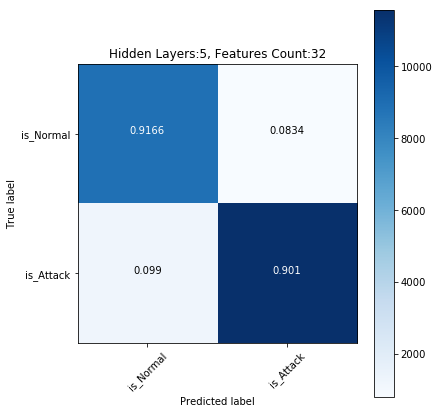

In [21]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Normalized confusion matrix
[[ 0.7128  0.2872]
 [ 0.1279  0.8721]]


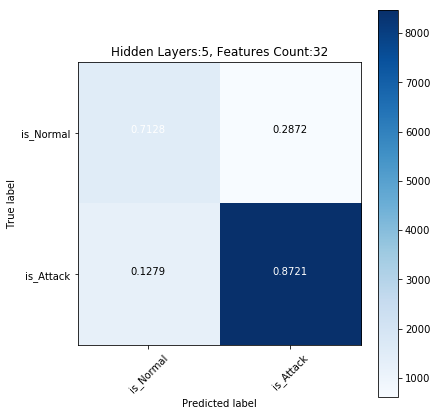

In [22]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [2]:
past_scores = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd-.pkl")

In [3]:
past_scores

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
1,1,40,0.871998,0.843728,0.708945,16.784830
8,1,40,0.868228,0.829977,0.685907,23.926728
32,1,40,0.912880,0.853531,0.724810,28.509531
122,1,40,0.904346,0.870653,0.765738,77.883018
1,3,40,0.805319,0.797906,0.696287,31.748681
8,3,40,0.938083,0.870387,0.760591,44.357380
32,3,40,0.894423,0.823722,0.681519,11.989715
122,3,40,0.908315,0.891102,0.806498,31.189773
1,5,40,0.844017,0.782470,0.669451,11.284715


In [4]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.max().sort_values(by="test_score", ascending = False)

,,epoch,train_score,test_score,test_score_20,time_taken
no_of_features,hidden_layers,,,,,
32,5,40,0.940266,0.907692,0.843207,112.778826
8,3,40,0.938083,0.906893,0.849536,47.314576
122,5,40,0.934709,0.900994,0.833755,87.583468
32,3,40,0.926374,0.896114,0.818650,62.732789
122,3,40,0.936694,0.893453,0.809283,79.632214
8,5,40,0.937488,0.890703,0.830802,54.646678
122,1,40,0.939075,0.890303,0.792574,77.883018
1,5,40,0.910498,0.884847,0.820422,84.671053
32,1,40,0.945624,0.882363,0.809536,28.509531


In [5]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.min().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
122            1                 40     0.860488    0.844304       0.710970   
8              3                 40     0.831316    0.835522       0.689789   
122            5                 40     0.788053    0.832771       0.696624   
32             5                 40     0.726533    0.832328       0.708186   
               3                 40     0.814646    0.823722       0.681519   
               1                 40     0.823179    0.819242       0.660506   
8              1                 40     0.868228    0.810681       0.646076   
               5                 40     0.770788    0.779720       0.608523   
122            3                 40     0.826751    0.755589       0.565992   
1              3                 40     0.739829    0.753593       0.588354   
               1                 40     0.774757    0.684927       0.421181   
               5                 40     0.552094    0.560105       0.505907   

                              time_taken  
no_of_features hidden_layers              
122            1                2.524849  
8              3                4.317577  
122            5                2.332694  
32             5                2.104447  
               3                7.476064  
               1                5.120272  
8              1                2.288514  
               5                2.160671  
122            3                1.718477  
1              3                1.404578  
               1                1.938163  
               5                2.099397

In [6]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
32             5                 40     0.887613    0.872546       0.781239   
8              3                 40     0.905167    0.870766       0.768458   
122            5                 40     0.891826    0.868231       0.774871   
               1                 40     0.902975    0.864070       0.750357   
32             3                 40     0.902335    0.861777       0.752512   
8              5                 40     0.868742    0.850111       0.745811   
32             1                 40     0.894865    0.846557       0.717334   
8              1                 40     0.893720    0.840532       0.704315   
122            3                 40     0.888244    0.839840       0.726045   
1              1                 40     0.862509    0.822478       0.684047   
               3                 40     0.828637    0.802003       0.683069   
               5                 40     0.815728    0.793152       0.691166   

                              time_taken  
no_of_features hidden_layers              
32             5               30.410387  
8              3               21.097892  
122            5               27.389792  
               1               38.661592  
32             3               21.866662  
8              5               24.679213  
32             1               15.653951  
8              1               10.433857  
122            3               21.824074  
1              1                9.067344  
               3               27.819532  
               5               30.535571

In [7]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.std().sort_values(by="test_score", ascending = False)

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              5                0.0     0.080163    0.070988       0.068416   
               1                0.0     0.025107    0.036876       0.068964   
122            3                0.0     0.027430    0.036046       0.064125   
8              5                0.0     0.045393    0.027105       0.052455   
1              3                0.0     0.040910    0.022591       0.032194   
32             3                0.0     0.024845    0.020960       0.040294   
122            5                0.0     0.040290    0.020369       0.037242   
32             5                0.0     0.041061    0.019752       0.033215   
8              1                0.0     0.018418    0.018085       0.035539   
32             1                0.0     0.031827    0.017640       0.035196   
8              3                0.0     0.025052    0.015412       0.032726   
122            1                0.0     0.016389    0.013120       0.025418   

                              time_taken  
no_of_features hidden_layers              
1              5               21.171301  
               1                5.749955  
122            3               19.357103  
8              5               16.168768  
1              3               17.912097  
32             3               14.951176  
122            5               25.606635  
32             5               25.798630  
8              1                7.066276  
32             1                6.431438  
8              3               12.794560  
122            1               20.160569